# 캐글 참여 프로젝트: 회귀 = 집값 예측

https://www.kaggle.com/t/05f287fe67bb43298d8c3e66a1e71c27

# House Prices 🏠

In [314]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from scipy.stats import skew

house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [315]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtFinType2      24
BsmtExposure      24
BsmtFinType1      23
BsmtCond          23
BsmtQual          23
MasVnrArea         8
Electrical         1
dtype: int64


### 데이터 검토

파악된 데이터 특징
- train 구축연도 1872 ~ 2010 vs test 구축연도 1880 ~ 2009 
- train, test 각종 컬럼의 mean 등이 유사한 것으로 보아 편향 없어보임
- SaleCondition에 abnormal(비정상), partial(일부 공간만 판매?)과 같이 이상치일 것 같은 값이 확인되지만 test 데이터에도 발생하기 때문에 삭제하지 않음
- 해당 지역 집값은 하락하는 추세
- 2010년 7월 집값이 폭락한 것처럼 표시되지만, 7월 데이터가 적어 기존 18만대 평균에 비해 11만으로 확인되어 2010년 7월 데이터만 삭제


데이터 전처리 
1. SalesPrice 50만 이상 삭제
2. GrLivArea 4000 이상 삭제
3. 2010년 7월 데이터 삭제
4. id를 제외한 null 많은 컬럼 삭제
5. 수치형에서 null을 평균으로 fill
6. Train=SalePrice 제외한 데이터 중에서 수치형 데이터만 standard scaling
7. Train=SalePrice 다시 Id 기준 merge
8. Train=Id 삭제
9. Test= 수치형 데이터 standard scaling
10. object를 원핫인코딩(dtype=int)
11. 기타 test 데이터 전처리

In [316]:
house_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.00000,950.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1160.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,728.528253,56.97774,70.058947,10336.357877,6.105308,5.595890,1971.201199,1985.021404,102.938793,442.928938,...,90.971747,47.554795,22.715753,3.219178,16.332192,2.955479,51.279110,6.306507,2007.830479,180194.401541
std,415.393477,42.29068,24.762405,8784.854640,1.373032,1.127388,30.362445,20.693264,176.142597,462.364719,...,123.811685,68.250085,63.042971,29.241246,58.828037,41.648504,552.357575,2.715955,1.323583,78869.201529
min,1.000000,20.00000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,373.750000,20.00000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1966.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129500.000000
50%,720.500000,50.00000,69.000000,9446.000000,6.000000,5.000000,1972.500000,1994.000000,0.000000,374.500000,...,0.000000,25.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163995.000000
75%,1086.250000,70.00000,80.000000,11601.500000,7.000000,6.000000,2001.000000,2004.000000,168.000000,714.500000,...,165.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213062.500000
max,1460.000000,190.00000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1170.000000,5644.000000,...,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [317]:
house_df_test_org = pd.read_csv('test.csv')
house_df_test = house_df_test_org.copy()
house_df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,292.000000,292.000000,251.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,738.386986,56.575342,70.015936,11238.708904,6.075342,5.493151,1971.534247,1984.243151,106.650685,446.482877,...,485.345890,107.335616,43.082192,18.907534,4.171233,9.976027,1.972603,12.328767,6.383562,2007.756849
std,446.267296,42.411231,22.431579,13760.587036,1.424313,1.050260,29.605926,20.476265,199.728307,430.869117,...,214.524168,130.670135,57.561025,52.714510,29.658042,40.940441,33.707850,96.513383,2.657442,1.346672
min,2.000000,20.000000,21.000000,1680.000000,3.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,305.000000,20.000000,60.000000,7500.000000,5.000000,5.000000,1953.750000,1967.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,762.000000,50.000000,70.000000,9539.500000,6.000000,5.000000,1973.500000,1992.500000,0.000000,401.500000,...,480.000000,58.500000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1136.000000,60.000000,80.000000,11604.000000,7.000000,6.000000,1999.000000,2003.000000,157.000000,695.500000,...,588.000000,192.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1459.000000,190.000000,150.000000,215245.000000,10.000000,9.000000,2009.000000,2009.000000,1600.000000,1810.000000,...,1356.000000,857.000000,267.000000,286.000000,304.000000,288.000000,576.000000,1300.000000,12.000000,2010.000000


In [318]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

In [319]:
house_df['SaleCondition'].value_counts()

SaleCondition
Normal     959
Partial     99
Abnorml     78
Family      17
Alloca      11
AdjLand      4
Name: count, dtype: int64

In [320]:
house_df_test['SaleCondition'].value_counts()

SaleCondition
Normal     239
Partial     26
Abnorml     23
Family       3
Alloca       1
Name: count, dtype: int64

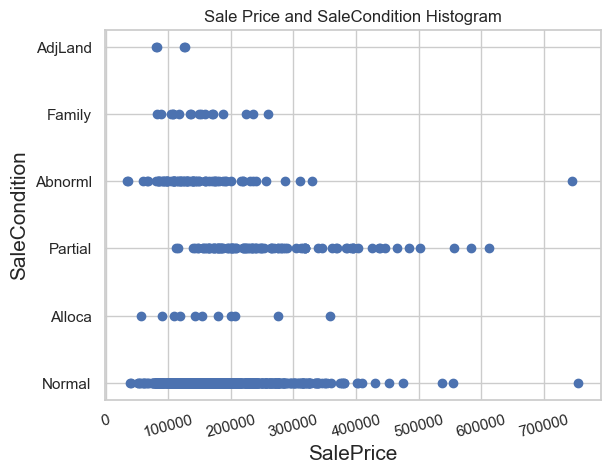

In [321]:
plt.title('Sale Price and SaleCondition Histogram')
plt.xticks(rotation=15)
plt.scatter(data=house_df, y = 'SaleCondition', x = 'SalePrice')
plt.xlabel('SalePrice', fontsize=15)
plt.ylabel('SaleCondition', fontsize=15)
plt.show()

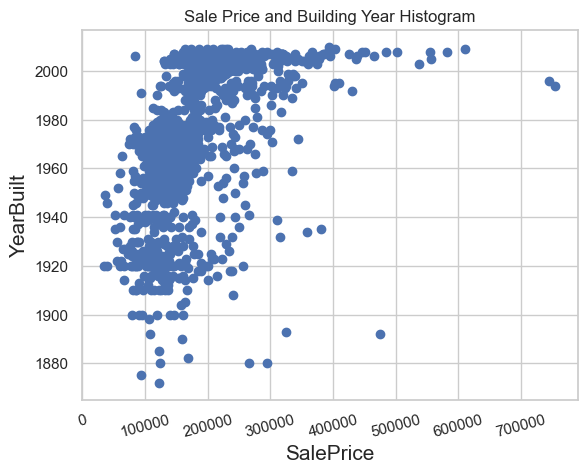

In [322]:
plt.title('Sale Price and Building Year Histogram')
plt.xticks(rotation=15)
plt.scatter(data=house_df, y = 'YearBuilt', x = 'SalePrice')
plt.xlabel('SalePrice', fontsize=15)
plt.ylabel('YearBuilt', fontsize=15)
plt.show()

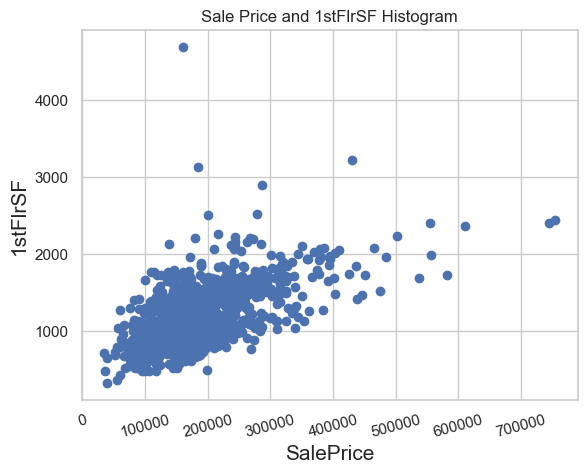

In [323]:
plt.title('Sale Price and 1stFlrSF Histogram')
plt.xticks(rotation=15)
plt.scatter(data=house_df, y = '1stFlrSF', x = 'SalePrice')
plt.xlabel('SalePrice', fontsize=15)
plt.ylabel('1stFlrSF', fontsize=15)
plt.show()

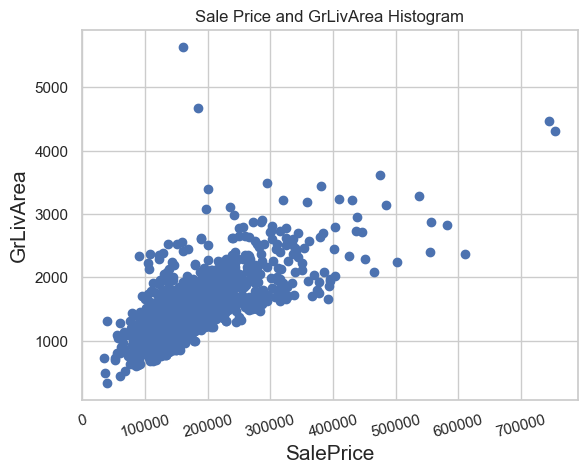

In [324]:
plt.title('Sale Price and GrLivArea Histogram')
plt.xticks(rotation=15)
plt.scatter(data=house_df, y = 'GrLivArea', x = 'SalePrice')
plt.xlabel('SalePrice', fontsize=15)
plt.ylabel('GrLivArea', fontsize=15)
plt.show()

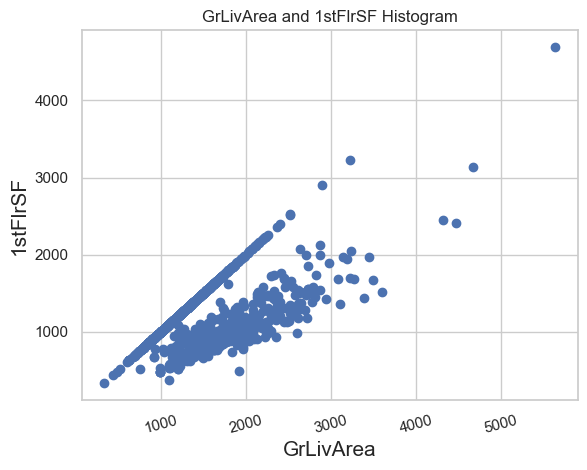

In [325]:
plt.title('GrLivArea and 1stFlrSF Histogram')
plt.xticks(rotation=15)
plt.scatter(data=house_df, y = '1stFlrSF', x = 'GrLivArea')
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('1stFlrSF', fontsize=15)
plt.show()

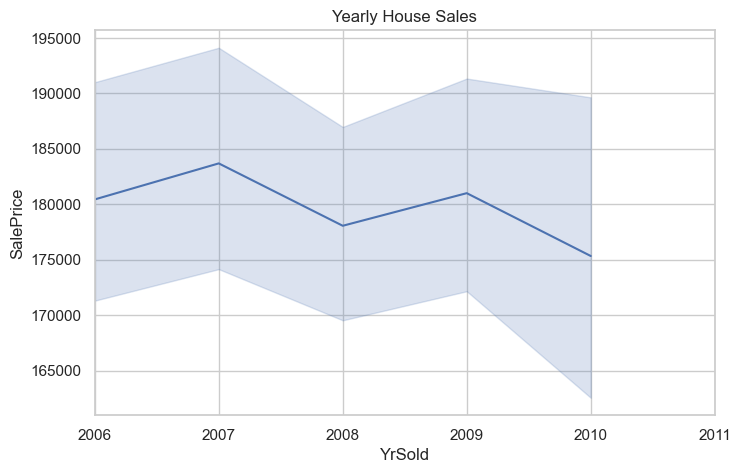

In [326]:
plt.figure(figsize=(8,5))
sns.set_theme(style="whitegrid")
sns.lineplot(data=house_df, x = 'YrSold', y = 'SalePrice')
plt.xlim(2006,2011)
plt.title('Yearly House Sales')
plt.show()

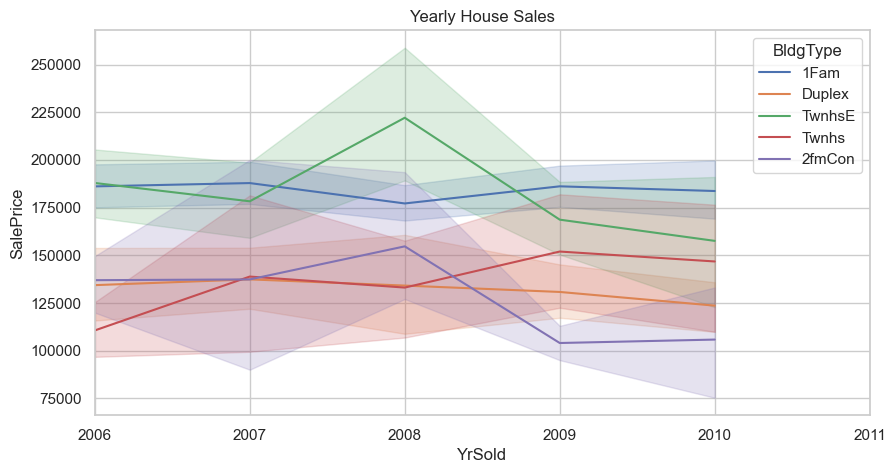

In [327]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
sns.lineplot(data=house_df, x = 'YrSold', y = 'SalePrice', hue = 'BldgType')
plt.xlim(2006,2011)
plt.title('Yearly House Sales')
plt.show()

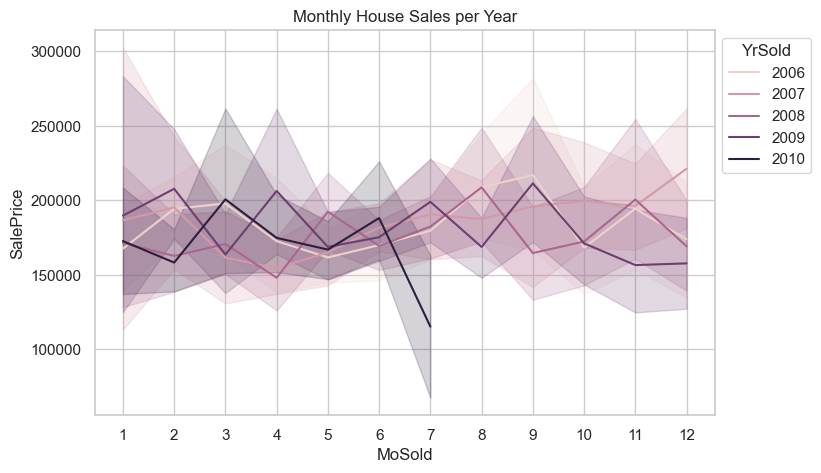

In [328]:
plt.figure(figsize=(8,5))
# sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=house_df, x = 'MoSold', y = 'SalePrice', hue = 'YrSold')
plt.xticks(np.arange(1,13,1))
plt.title('Monthly House Sales per Year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

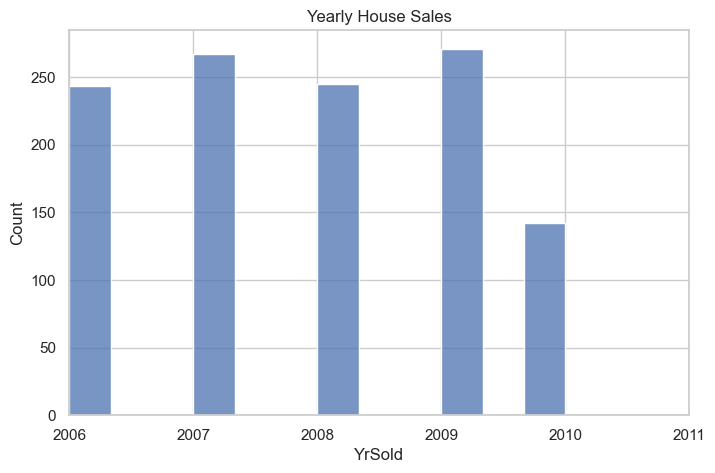

In [329]:
plt.figure(figsize=(8,5))
sns.set_theme(style="whitegrid")
sns.histplot(data=house_df, x = 'YrSold')
plt.title('Yearly House Sales')
plt.xlim(2006,2011)
plt.show()

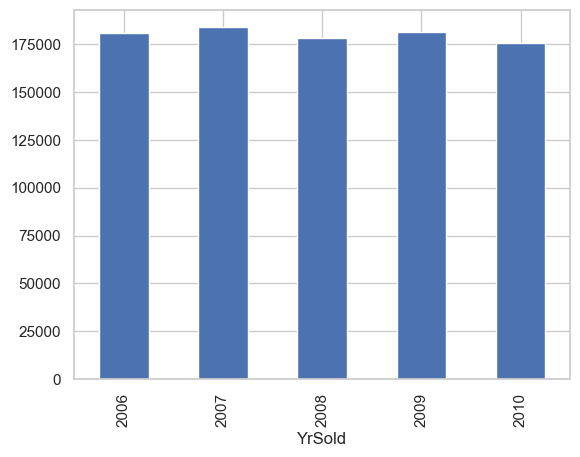

In [330]:
house_df.groupby('YrSold')['SalePrice'].mean().plot(kind='bar')
plt.show()

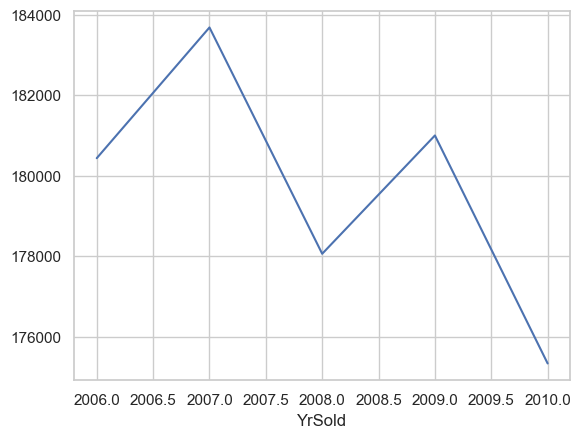

In [331]:
house_df.groupby('YrSold')['SalePrice'].mean().plot(kind='line')
plt.show()

In [332]:
a_df = house_df[(house_df['YrSold'] == 2010) & (house_df['MoSold'] == 7)]

mean_price = a_df['SalePrice'].mean()
print(mean_price)

115250.0


In [333]:
cond1 = house_df['GrLivArea'] > 4000
cond2 = house_df['SalePrice'] < 500000
outlier_index = house_df[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df shape:', house_df.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df shape:', house_df.shape)


아웃라이어 레코드 index : [ 64 373]
아웃라이어 삭제 전 house_df shape: (1168, 81)
아웃라이어 삭제 후 house_df shape: (1166, 81)


In [334]:
print('아웃라이어 삭제 전 house_df shape:', house_df.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
condition = (house_df['YrSold'] == 2010) & (house_df['MoSold'] == 7)
house_df.drop(index=house_df[condition].index, inplace=True)
print('아웃라이어 삭제 후 house_df shape:', house_df.shape)


아웃라이어 삭제 전 house_df shape: (1166, 81)
아웃라이어 삭제 후 house_df shape: (1162, 81)


In [335]:
# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제 (ID 제외)
house_df.drop(['PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
# house_df.fillna(house_df.mean(),inplace=True)
num_cols = house_df.select_dtypes(include=['number']).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())


# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [336]:
house_df_2 = house_df.drop('SalePrice',axis=1, inplace=False)

In [337]:
numeric_cols = list(house_df_2.select_dtypes(include=['int64', 'float64']).columns)
numeric_cols.pop(0)
print(numeric_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [338]:
# train 데이터 scaling (price 제외)

In [339]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
house_df_2[numeric_cols] = scaler.fit_transform(house_df_2[numeric_cols])

In [340]:
house_df_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,968,-0.875648,RL,0.000000,-0.334054,Pave,IR1,Lvl,AllPub,Inside,...,-0.702970,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,0.133646,WD,Normal
1,739,0.795129,RL,-0.464503,0.062045,Pave,Reg,Lvl,AllPub,Inside,...,-0.702970,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,-1.217556,0.891191,WD,Alloca
2,696,-0.875648,RL,-0.748954,0.411797,Pave,IR1,Lvl,AllPub,Inside,...,-0.702970,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,-1.381444,WD,Normal
3,239,-0.875648,RL,1.099977,0.204920,Pave,Reg,Lvl,AllPub,Inside,...,2.692756,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,2.097519,-0.623899,New,Partial
4,891,-0.159601,RL,-0.464503,-0.255764,Pave,Reg,Lvl,AllPub,Corner,...,-0.702970,-0.361527,-0.110425,-0.278517,-0.065048,3.585917,0.255810,-0.623899,WD,Normal


In [341]:
house_df_3 = house_df.copy()

In [342]:
house_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1162 entries, 0 to 1167
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1162 non-null   int64  
 1   MSSubClass     1162 non-null   int64  
 2   MSZoning       1162 non-null   object 
 3   LotFrontage    1162 non-null   float64
 4   LotArea        1162 non-null   int64  
 5   Street         1162 non-null   object 
 6   LotShape       1162 non-null   object 
 7   LandContour    1162 non-null   object 
 8   Utilities      1162 non-null   object 
 9   LotConfig      1162 non-null   object 
 10  LandSlope      1162 non-null   object 
 11  Neighborhood   1162 non-null   object 
 12  Condition1     1162 non-null   object 
 13  Condition2     1162 non-null   object 
 14  BldgType       1162 non-null   object 
 15  HouseStyle     1162 non-null   object 
 16  OverallQual    1162 non-null   int64  
 17  OverallCond    1162 non-null   int64  
 18  YearBuilt    

In [343]:
select_col = list(house_df_3.columns[[0,75]])
house_df_3 = house_df_3[select_col]
house_df_3.head()

,Id,SalePrice
0,968,135000
1,739,179000
2,696,176000
3,239,318000
4,891,122900


In [344]:
house_df_2 = house_df_2.merge(house_df_3, on ='Id', how='left')
house_df_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,-0.875648,RL,0.000000,-0.334054,Pave,IR1,Lvl,AllPub,Inside,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,0.133646,WD,Normal,135000
1,739,0.795129,RL,-0.464503,0.062045,Pave,Reg,Lvl,AllPub,Inside,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,-1.217556,0.891191,WD,Alloca,179000
2,696,-0.875648,RL,-0.748954,0.411797,Pave,IR1,Lvl,AllPub,Inside,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,-1.381444,WD,Normal,176000
3,239,-0.875648,RL,1.099977,0.204920,Pave,Reg,Lvl,AllPub,Inside,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,2.097519,-0.623899,New,Partial,318000
4,891,-0.159601,RL,-0.464503,-0.255764,Pave,Reg,Lvl,AllPub,Corner,...,-0.361527,-0.110425,-0.278517,-0.065048,3.585917,0.255810,-0.623899,WD,Normal,122900


In [345]:
house_df_2['MSSubClass'].isna().sum()

0

In [346]:
house_df_2.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [347]:
# ID 삭제
house_df_2.drop(['Id' ], axis=1 , inplace=True)

In [348]:
house_df_test_2 = house_df_test.copy()

In [349]:
numeric_cols = list(house_df_test_2.select_dtypes(include=['int64', 'float64']).columns)
numeric_cols.pop(0)
print(numeric_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [350]:
# test 데이터도 scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
house_df_test_2[numeric_cols] = scaler.fit_transform(house_df_test_2[numeric_cols])

In [351]:
house_df_test_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,86,0.080887,RL,2.277411,0.350898,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,-0.898478,-1.306825,WD,Normal
1,227,0.080887,RL,0.535317,-0.093813,Pave,NaN,IR1,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,-0.144583,-0.562979,WD,Abnorml
2,492,-0.155304,RL,0.401310,-0.127299,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,MnPrv,NaN,-0.127961,0.609313,-1.306825,WD,Normal
3,64,0.317079,RM,-0.894093,-0.068334,Pave,NaN,IR1,Bnk,AllPub,...,-0.24409,-0.058621,NaN,GdPrv,NaN,-0.127961,-0.898478,1.668558,WD,Normal
4,576,-0.155304,RL,0.445979,-0.200823,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,1.363208,0.180867,COD,Abnorml


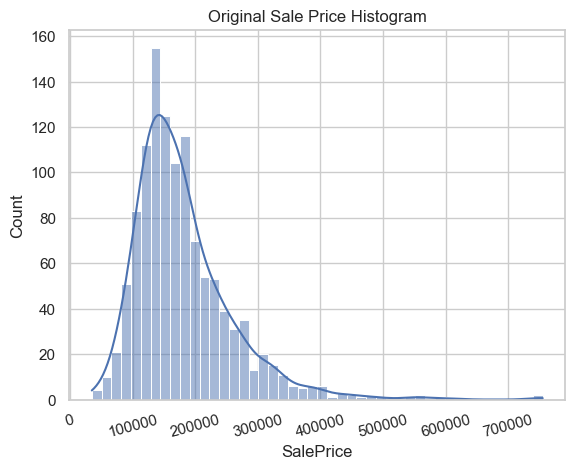

In [352]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df_2['SalePrice'], kde=True)
plt.show()

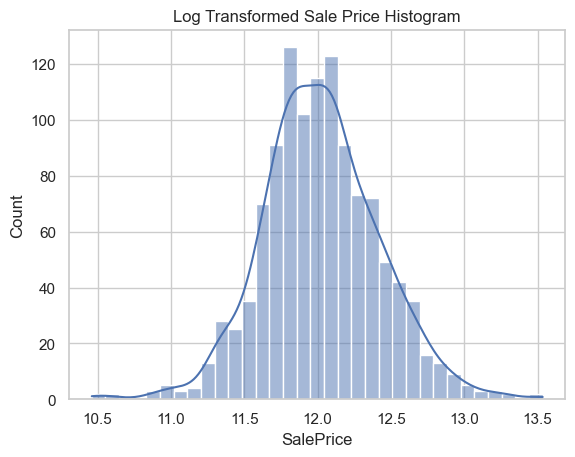

In [353]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df_2['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [354]:
# SalePrice 로그 변환
original_SalePrice = house_df_2['SalePrice']
house_df_2['SalePrice'] = np.log1p(house_df_2['SalePrice'])


In [355]:
house_df_2.shape

(1162, 75)

In [356]:
isnull_series = house_df_2.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  MasVnrType      691
GarageType       68
GarageFinish     68
GarageQual       68
GarageCond       68
BsmtExposure     23
BsmtFinType2     23
BsmtQual         22
BsmtCond         22
BsmtFinType1     22
Electrical        1
dtype: int64


In [357]:
house_df_2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-0.875648,RL,0.000000,-0.334054,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,0.133646,WD,Normal,11.813037
1,0.795129,RL,-0.464503,0.062045,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,-1.217556,0.891191,WD,Alloca,12.095147
2,-0.875648,RL,-0.748954,0.411797,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,0.255810,-1.381444,WD,Normal,12.078245
3,-0.875648,RL,1.099977,0.204920,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,-0.361527,-0.110425,-0.278517,-0.065048,-0.089180,2.097519,-0.623899,New,Partial,12.669810
4,-0.159601,RL,-0.464503,-0.255764,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,-0.361527,-0.110425,-0.278517,-0.065048,3.585917,0.255810,-0.623899,WD,Normal,11.719134


In [358]:
house_df_ohe = pd.get_dummies(house_df_2)


In [359]:
# plt.figure(figsize=(12,12))
# corr = house_df_ohe.corr()
# sns.heatmap(corr, 
#             # annot=True, fmt='.1f', 
#             cmap='RdBu')
# plt.show()

In [360]:
from sklearn.model_selection import train_test_split
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)


In [361]:
print(np.any(np.isnan(X_test)))     # True면 NaN 있음
print(np.any(np.isinf(X_test)))     # True면 inf 있음

False
False


In [362]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)
print(y_test_exp.mean())
print(mean_squared_error(y_test_exp, pred_exp))
print(np.sqrt(mean_squared_error(y_test_exp, pred_exp)))
print(np.sqrt(mean_squared_log_error(y_test_exp, pred_exp)))
r2_score(y_test_exp, pred)

168274.1931330472
512400505.28153896
22636.265267961917
0.143256350142509


-5.8280210697837225

In [363]:
import matplotlib.pyplot as plt
train_score = []
test_score = []

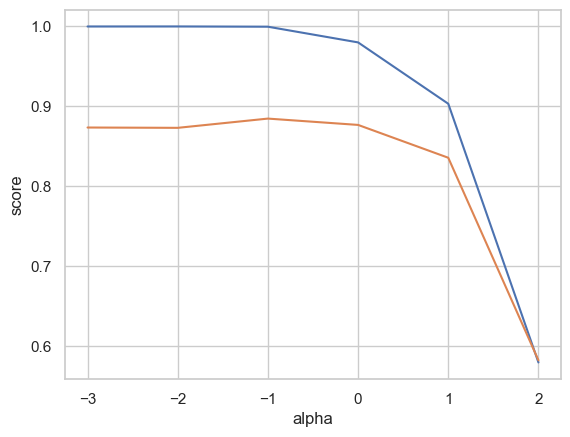

In [364]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
  model = XGBRegressor(alpha=alpha)
  model.fit(X_train, y_train)
  train_score.append(model.score(X_train, y_train))
  test_score.append(model.score(X_test, y_test))


plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()  

In [389]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
XGmodel = XGBRegressor(alpha = 0.001)
XGmodel.fit(X_train, y_train)
pred = XGmodel.predict(X_test)
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)
print(y_test_exp.mean())
print(mean_squared_error(y_test_exp, pred_exp)) # MSE
print(np.sqrt(mean_squared_error(y_test_exp, pred_exp))) # RMSE
print(np.sqrt(mean_squared_log_error(y_test_exp, pred_exp)))
print(r2_score(y_test_exp, pred))

168274.1931330472
444707821.76372135
21088.096684236854
0.13122060168696725
-5.828021419029832


In [366]:
Lamodel=Lasso(alpha = 0.01) 
Lamodel.fit(X_train, y_train)
pred = Lamodel.predict(X_test)
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)
print(y_test_exp.mean())
print(mean_squared_error(y_test_exp, pred_exp)) # MSE
print(np.sqrt(mean_squared_error(y_test_exp, pred_exp))) # RMSE
print(np.sqrt(mean_squared_log_error(y_test_exp, pred_exp)))
print(r2_score(y_test_exp, pred))

168274.1931330472
549034937.2037262
23431.494557618942
0.1276759807991901
-5.828022434384858


In [367]:
Rimodel=Ridge(alpha = 0.001) 
Rimodel.fit(X_train, y_train)
pred = Rimodel.predict(X_test)
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)
print(y_test_exp.mean())
print(mean_squared_error(y_test_exp, pred_exp)) # MSE
print(np.sqrt(mean_squared_error(y_test_exp, pred_exp))) # RMSE
print(np.sqrt(mean_squared_log_error(y_test_exp, pred_exp)))
print(r2_score(y_test_exp, pred))

168274.1931330472
400358426.9181673
20008.958666511542
0.12151537723967787
-5.828021201714577


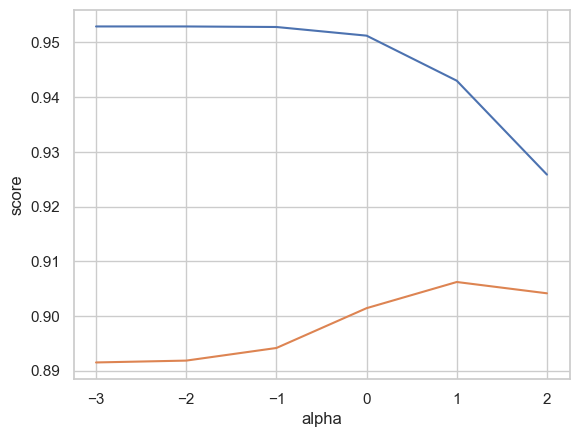

In [368]:
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
  model = Ridge(alpha=alpha)
  model.fit(X_train, y_train)
  train_score.append(model.score(X_train, y_train))
  test_score.append(model.score(X_test, y_test))


plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()  

In [400]:
from lightgbm import LGBMRegressor

LGmodel=LGBMRegressor(alpha = 0.001) 
LGmodel.fit(X_train, y_train)
pred = LGmodel.predict(X_test)
pred_exp = np.expm1(pred)
y_test_exp = np.expm1(y_test)
print(y_test_exp.mean())
print(mean_squared_error(y_test_exp, pred_exp)) # MSE
print(np.sqrt(mean_squared_error(y_test_exp, pred_exp))) # RMSE
print(np.sqrt(mean_squared_log_error(y_test_exp, pred_exp)))
print(r2_score(y_test_exp, pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2996
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 154
[LightGBM] [Info] Start training from score 12.036989
168274.1931330472
378494361.61723787
19454.93155005275
0.12289319672642052
-5.828021912181347


# 제출용 Test 데이터 전처리 진행

### train에 진행된 전처리
- NUll 많은 컬럼 삭제
- skew 컬럼 로그 변환
- 원핫 인코딩

결과값의 컬럼 개수가 266개여야한다

또 test와 train의 원핫인코딩 이후 개수가 달라지는 현상이 발생하게되는데

이때는 값이 너무 많아서
```
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)
```
이런 방식으로 train과 열 개수를 맞춰주는 방식을 사용해봄
- 다른 방식을 사용해보셔도 좋습니다~

In [370]:
X_train.shape

(929, 265)

In [371]:
list(house_df[num_cols])

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [372]:
house_df_test_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,86,0.080887,RL,2.277411,0.350898,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,-0.898478,-1.306825,WD,Normal
1,227,0.080887,RL,0.535317,-0.093813,Pave,NaN,IR1,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,-0.144583,-0.562979,WD,Abnorml
2,492,-0.155304,RL,0.401310,-0.127299,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,MnPrv,NaN,-0.127961,0.609313,-1.306825,WD,Normal
3,64,0.317079,RM,-0.894093,-0.068334,Pave,NaN,IR1,Bnk,AllPub,...,-0.24409,-0.058621,NaN,GdPrv,NaN,-0.127961,-0.898478,1.668558,WD,Normal
4,576,-0.155304,RL,0.445979,-0.200823,Pave,NaN,Reg,Lvl,AllPub,...,-0.24409,-0.058621,NaN,NaN,NaN,-0.127961,1.363208,0.180867,COD,Abnorml


In [373]:
print(np.any(np.isnan(X_test)))     # True면 NaN 있음
print(np.any(np.isinf(X_test)))     # True면 inf 있음

False
False


In [374]:
## test_data를 받아오기

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
# house_df_test_2.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
test = house_df_test_2

num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(house_df[num_cols].mean())  
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# valid_skew_cols = [col for col in skew_features_top.index if col in test_ohe2.columns]

# 편향 전처리 진행

# test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
# test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(292, 265)

In [375]:
house_df_test_2.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

# lgbm으로 제출

In [376]:
## sample_data를 받아오기
sample = pd.read_csv('./sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [401]:

pred = LGmodel.predict(test_ohe2)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)

In [402]:
# 제출부분과 크기가 맞는지 확인
pred_exp.shape

(292,)

In [403]:
pred_exp

array([232196.39512881, 268004.42856434, 159101.46894675, 134484.34498155,
       117446.25654956, 279436.75546792, 220827.12099773, 100729.51991427,
       162915.8066057 , 139391.25840867, 302662.98608261, 228661.93687634,
        79600.64626387,  88835.82613523, 141548.99160119, 134376.61393857,
       124799.58324493, 291698.32340849, 241647.30274694, 109987.08674758,
       200404.54550234, 147909.36242413, 144855.87156308, 196613.97320796,
       121090.1666224 , 184661.61395053, 143673.80082793, 148595.08105541,
       369582.52947789, 197843.31007136, 185984.40708475, 166309.56001336,
       165456.25861023, 159188.28764399, 175004.69562196, 339798.79064561,
       114646.24028803, 197469.79885563, 246050.91358805, 139565.99879526,
       291937.26753453, 202612.07080774, 123380.98463667, 295569.92040684,
       114764.60882586, 170621.65608717, 126172.7260691 , 138284.1453472 ,
       209369.00458674, 160654.6351409 , 186519.92090598, 140418.96557563,
       205920.45715842, 1